<a href="https://colab.research.google.com/github/tmtakashi/GAN_MNIST/blob/master/DCGAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://qiita.com/triwave33/items/35b4adc9f5b41c5e8141
from keras.layers import Dense, Conv2D, UpSampling2D, Activation, LeakyReLU, BatchNormalization, Reshape, Flatten, Input, Dropout
from keras.models import Sequential
from keras.optimizers import Adam

import numpy as np

class DCGAN():
  def __init__(self):
    # MNISTの入力サイズ
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)

    # 潜在変数の次元数
    self.z_dim =100

    optimizer = Adam(0.0002, 0.5)

    # Discriminatorモデル
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy',
                               optimizer=optimizer,
                               metrics=['accuracy'])

    # Generatorモデル
    self.generator = self.build_generator()
    # Generatorは単体では学習しないのでコンパイルは必要ない

    self.combined = self.build_combined1()
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
  def build_generator(self):
    noise_shape = (self.z_dim, )
    model = Sequential()

    model.add(Dense(1024, input_shape=noise_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(128*7*7)) #畳み込み層に(7, 7)の画像として与える
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Reshape((7, 7, 128), input_shape=(128*7*7,)))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(1, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    model.summary()
    
    return model

  def build_discriminator(self):
    img_shape = (self.img_rows, self.img_cols, self.channels)

    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=img_shape))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

  def build_combined1(self):
    self.discriminator.trainable = False
    model = Sequential([self.generator, self.discriminator])
    return model

  def build_combined2(self):
    z = Input(shape=(self.z_dim,))
    img = self.generator(z)
    self.discriminator.trainable = False
    valid = self.discriminator(img)
    model = Model(z, valid)
    model.summary()
    return model

  def train(self, iterations, batch_size=128, save_interval=50):

    #　MNIST読み込み
    from keras.datasets import mnist
    (x_train, _), (_, _) = mnist.load_data()

    # 正規化
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    # チャンネル次元を増やす
    x_train = np.expand_dims(x_train, axis=3)

    half_batch = int(batch_size / 2)

    for i in range(iterations):

      # -------------------------
      # Discriminatorの学習
      # -------------------------

      # バッチサイズの半数をGeneratorから生成
      noise = np.random.normal(0, 1, (half_batch, self.z_dim))
      gen_imgs = self.generator.predict(noise)

      # バッチサイズの半数を教師データからピックアップ
      idx = np.random.randint(0, x_train.shape[0], half_batch)
      imgs = x_train[idx]

      # Discriminatorを学習
      # 本物データと偽物データは別々に学習させる
      d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1))) # 本物
      d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))) # 偽物
      # それぞれの損失関数を平均
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      # -----------------------
      # Generatorの学習
      # -----------------------

      noise = np.random.normal(0, 1, (batch_size, self.z_dim))

      # 生成データの正解データは本物
      valid_y = np.array([1] * batch_size)

      # Generatorを学習
      g_loss = self.combined.train_on_batch(noise, valid_y)

      # 進捗の表示
      if i % 100 == 0:
        print("%d [ D loss: %f, acc.: %2.f%%] [G loss: %f]" % (i, d_loss[0], 100*d_loss[1], g_loss))

In [41]:
model1 = DCGAN()
model1.train(iterations=400)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 1024)              103424    
_________________________________________________________________
batch_normalization_46 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_77 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_64 (Dense)             (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_47 (Batc (None, 6272)              25088     
_________________________________________________________________
activation_78 (Activation)   (None, 6272)              0         
_________________________________________________________________
reshape_16 (Reshape)         (None, 7, 7, 128)         0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.751903, acc.: 53%] [G loss: 1.709454]
100 [ D loss: 0.787975, acc.: 42%] [G loss: 0.442028]
200 [ D loss: 0.536452, acc.: 77%] [G loss: 0.472413]
300 [ D loss: 0.639635, acc.: 67%] [G loss: 0.570345]


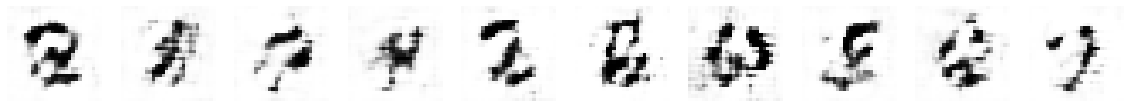

In [42]:
# 400 iteration
generated_img = model1.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [43]:
model2 = DCGAN()
model2.train(iterations=1000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 1024)              103424    
_________________________________________________________________
batch_normalization_49 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_82 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_68 (Dense)             (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_50 (Batc (None, 6272)              25088     
_________________________________________________________________
activation_83 (Activation)   (None, 6272)              0         
_________________________________________________________________
reshape_17 (Reshape)         (None, 7, 7, 128)         0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.721532, acc.: 20%] [G loss: 0.943402]
100 [ D loss: 0.591787, acc.: 74%] [G loss: 0.386529]
200 [ D loss: 0.627870, acc.: 63%] [G loss: 0.367138]
300 [ D loss: 0.645242, acc.: 65%] [G loss: 0.720271]
400 [ D loss: 0.497656, acc.: 79%] [G loss: 0.472244]
500 [ D loss: 0.566182, acc.: 74%] [G loss: 0.423925]
600 [ D loss: 0.418040, acc.: 82%] [G loss: 0.319244]
700 [ D loss: 0.449779, acc.: 80%] [G loss: 0.356430]
800 [ D loss: 0.477620, acc.: 78%] [G loss: 0.602705]
900 [ D loss: 0.497202, acc.: 78%] [G loss: 0.631035]


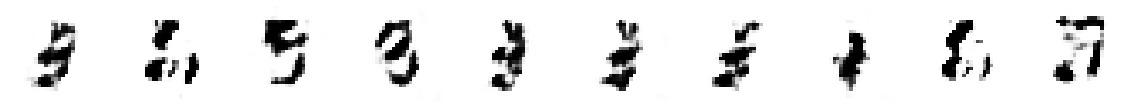

In [44]:
# 1000 iteration
generated_img = model2.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [45]:
model3 = DCGAN()
model3.train(iterations=5000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 1024)              103424    
_________________________________________________________________
batch_normalization_52 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_87 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_72 (Dense)             (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_53 (Batc (None, 6272)              25088     
_________________________________________________________________
activation_88 (Activation)   (None, 6272)              0         
_________________________________________________________________
reshape_18 (Reshape)         (None, 7, 7, 128)         0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.744345, acc.: 25%] [G loss: 0.239432]
100 [ D loss: 0.474261, acc.: 80%] [G loss: 0.338620]
200 [ D loss: 0.756195, acc.: 46%] [G loss: 0.390754]
300 [ D loss: 0.684683, acc.: 57%] [G loss: 0.540423]
400 [ D loss: 0.638130, acc.: 63%] [G loss: 0.572719]
500 [ D loss: 0.624034, acc.: 63%] [G loss: 0.415482]
600 [ D loss: 0.354498, acc.: 88%] [G loss: 0.248970]
700 [ D loss: 0.518878, acc.: 71%] [G loss: 0.475221]
800 [ D loss: 0.361347, acc.: 84%] [G loss: 0.148523]
900 [ D loss: 0.293054, acc.: 89%] [G loss: 0.183466]
1000 [ D loss: 0.333278, acc.: 88%] [G loss: 0.327391]
1100 [ D loss: 0.292302, acc.: 88%] [G loss: 0.144093]
1200 [ D loss: 0.358142, acc.: 85%] [G loss: 0.202870]
1300 [ D loss: 0.190488, acc.: 91%] [G loss: 0.492762]
1400 [ D loss: 0.246713, acc.: 91%] [G loss: 0.269303]
1500 [ D loss: 0.310008, acc.: 85%] [G loss: 0.402708]
1600 [ D loss: 0.533395, acc.: 74%] [G loss: 0.760924]
1700 [ D loss: 0.371975, acc.: 86%] [G loss: 1.468985]
1800 [ D loss: 0.55298

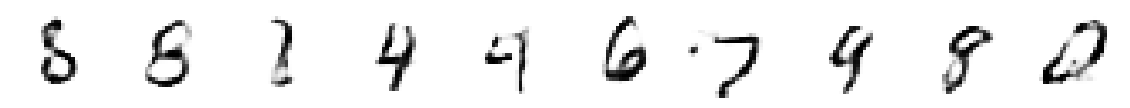

In [46]:
# 5000 iteration
from matplotlib import cm
generated_img = model3.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]), cmap=cm.gray_r)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

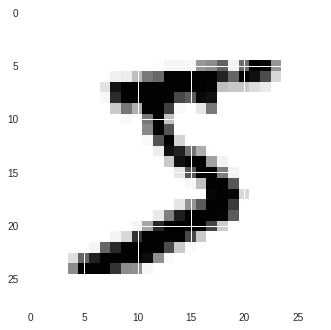

In [48]:
from keras.datasets  import mnist
(x_train, _), (_, _) = mnist.load_data()
import matplotlib.pyplot as plt

plt.imshow(x_train[0])

In [49]:
model5 = DCGAN()
model5.train(iterations=10000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 1024)              103424    
_________________________________________________________________
batch_normalization_58 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_97 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_80 (Dense)             (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_59 (Batc (None, 6272)              25088     
_________________________________________________________________
activation_98 (Activation)   (None, 6272)              0         
_________________________________________________________________
reshape_20 (Reshape)         (None, 7, 7, 128)         0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.689809, acc.: 48%] [G loss: 0.295970]
100 [ D loss: 0.936741, acc.: 38%] [G loss: 0.323381]
200 [ D loss: 0.731401, acc.: 45%] [G loss: 0.423115]
300 [ D loss: 0.678699, acc.: 57%] [G loss: 0.648059]
400 [ D loss: 0.638809, acc.: 62%] [G loss: 0.258137]
500 [ D loss: 0.547395, acc.: 67%] [G loss: 0.182245]
600 [ D loss: 0.379721, acc.: 86%] [G loss: 0.162121]
700 [ D loss: 0.322669, acc.: 91%] [G loss: 0.311511]
800 [ D loss: 0.434873, acc.: 77%] [G loss: 0.184091]
900 [ D loss: 0.459715, acc.: 76%] [G loss: 0.782148]
1000 [ D loss: 0.395708, acc.: 84%] [G loss: 0.321473]
1100 [ D loss: 0.430761, acc.: 83%] [G loss: 0.601243]
1200 [ D loss: 0.274639, acc.: 90%] [G loss: 0.478961]
1300 [ D loss: 0.289714, acc.: 89%] [G loss: 0.728320]
1400 [ D loss: 0.452531, acc.: 77%] [G loss: 0.690760]
1500 [ D loss: 0.450992, acc.: 79%] [G loss: 0.541431]
1600 [ D loss: 0.307781, acc.: 88%] [G loss: 0.409326]
1700 [ D loss: 0.302196, acc.: 88%] [G loss: 1.169298]
1800 [ D loss: 0.42207

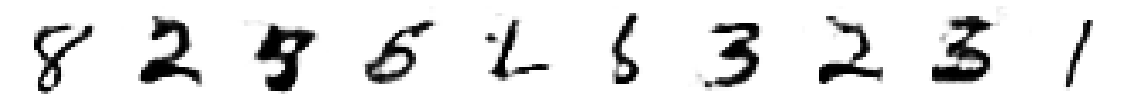

In [50]:
# 10000 iteration
generated_img = model5.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]), cmap=cm.gray_r)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [0]:
model4 = DCGAN()
model4.train(iterations=20000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 1024)              103424    
_________________________________________________________________
batch_normalization_64 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_107 (Activation)  (None, 1024)              0         
_________________________________________________________________
dense_88 (Dense)             (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_65 (Batc (None, 6272)              25088     
_________________________________________________________________
activation_108 (Activation)  (None, 6272)              0         
_________________________________________________________________
reshape_22 (Reshape)         (None, 7, 7, 128)         0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.728423, acc.: 55%] [G loss: 1.119257]
100 [ D loss: 0.701212, acc.: 49%] [G loss: 0.715881]
200 [ D loss: 0.443091, acc.: 83%] [G loss: 0.774487]
300 [ D loss: 0.620308, acc.: 65%] [G loss: 0.425206]
400 [ D loss: 0.423621, acc.: 78%] [G loss: 0.308229]
500 [ D loss: 0.372842, acc.: 85%] [G loss: 0.117268]
600 [ D loss: 0.455015, acc.: 79%] [G loss: 0.167992]
700 [ D loss: 0.350767, acc.: 84%] [G loss: 0.139540]
800 [ D loss: 0.418484, acc.: 77%] [G loss: 0.168473]
900 [ D loss: 0.481098, acc.: 73%] [G loss: 0.486193]
1000 [ D loss: 0.452743, acc.: 80%] [G loss: 0.410499]
1100 [ D loss: 0.405148, acc.: 84%] [G loss: 0.259333]
1200 [ D loss: 0.354854, acc.: 84%] [G loss: 0.199948]
1300 [ D loss: 0.502444, acc.: 73%] [G loss: 0.393126]
1400 [ D loss: 0.430383, acc.: 83%] [G loss: 0.891470]
1500 [ D loss: 0.429217, acc.: 82%] [G loss: 0.859046]
1600 [ D loss: 0.502337, acc.: 77%] [G loss: 0.793046]
1700 [ D loss: 0.356866, acc.: 88%] [G loss: 0.520906]
1800 [ D loss: 0.45860

In [0]:
# 20000 iteration
generated_img = model4.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]), cmap=cm.gray_r)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [0]:
# https://qiita.com/triwave33/items/35b4adc9f5b41c5e8141
from keras.layers import Dense, Conv2D, UpSampling2D, Activation, LeakyReLU, BatchNormalization, Reshape, Flatten, Input, Dropout
from keras.models import Sequential
from keras.optimizers import Adam

import numpy as np


# Generatorの学習率を半分にした
class DCGAN2():
  def __init__(self):
    # MNISTの入力サイズ
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)

    # 潜在変数の次元数
    self.z_dim =100

    optimizer = Adam(0.0002, 0.5)

    # Discriminatorモデル
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy',
                               optimizer=optimizer,
                               metrics=['accuracy'])

    # Generatorモデル
    self.generator = self.build_generator()
    # Generatorは単体では学習しないのでコンパイルは必要ない

    self.combined = self.build_combined1()
    self.combined.compile(loss='binary_crossentropy', optimizer= Adam(0.0001, 0.5))
    
  def build_generator(self):
    noise_shape = (self.z_dim, )
    model = Sequential()

    model.add(Dense(1024, input_shape=noise_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(128*7*7)) #畳み込み層に(7, 7)の画像として与える
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Reshape((7, 7, 128), input_shape=(128*7*7,)))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(1, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    model.summary()
    
    return model

  def build_discriminator(self):
    img_shape = (self.img_rows, self.img_cols, self.channels)

    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=img_shape))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

  def build_combined1(self):
    self.discriminator.trainable = False
    model = Sequential([self.generator, self.discriminator])
    return model

  def build_combined2(self):
    z = Input(shape=(self.z_dim,))
    img = self.generator(z)
    self.discriminator.trainable = False
    valid = self.discriminator(img)
    model = Model(z, valid)
    model.summary()
    return model

  def train(self, iterations, batch_size=128, save_interval=50):

    #　MNIST読み込み
    from keras.datasets import mnist
    (x_train, _), (_, _) = mnist.load_data()

    # 正規化
    x_train = x_train / 255.
    # チャンネル次元を増やす
    x_train = np.expand_dims(x_train, axis=3)

    half_batch = int(batch_size / 2)

    for i in range(iterations):

      # -------------------------
      # Discriminatorの学習
      # -------------------------

      # バッチサイズの半数をGeneratorから生成
      noise = np.random.normal(0, 1, (half_batch, self.z_dim))
      gen_imgs = self.generator.predict(noise)

      # バッチサイズの半数を教師データからピックアップ
      idx = np.random.randint(0, x_train.shape[0], half_batch)
      imgs = x_train[idx]

      # Discriminatorを学習
      # 本物データと偽物データは別々に学習させる
      d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1))) # 本物
      d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))) # 偽物
      # それぞれの損失関数を平均
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      # -----------------------
      # Generatorの学習
      # -----------------------

      noise = np.random.normal(0, 1, (batch_size, self.z_dim))

      # 生成データの正解データは本物
      valid_y = np.array([1] * batch_size)

      # Generatorを学習
      g_loss = self.combined.train_on_batch(noise, valid_y)

      # 進捗の表示
      if i % 100 == 0:
        print("%d [ D loss: %f, acc.: %2.f%%] [G loss: %f]" % (i, d_loss[0], 100*d_loss[1], g_loss))

In [21]:
model1_2 = DCGAN2()
model1_2.train(iterations=400)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 1024)              103424    
_________________________________________________________________
batch_normalization_19 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_32 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_20 (Batc (None, 6272)              25088     
_________________________________________________________________
activation_33 (Activation)   (None, 6272)              0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 7, 7, 128)         0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.691843, acc.: 46%] [G loss: 0.911154]
100 [ D loss: 0.015280, acc.: 100%] [G loss: 0.378039]
200 [ D loss: 0.010440, acc.: 100%] [G loss: 0.402239]
300 [ D loss: 0.004172, acc.: 100%] [G loss: 0.090059]


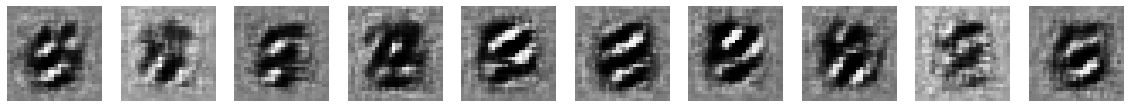

In [22]:
# 400 iteration
generated_img = model1_2.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]), cmap=cm.gray_r)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [23]:
model2_2 = DCGAN2()
model2_2.train(iterations=400, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 1024)              103424    
_________________________________________________________________
batch_normalization_22 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_37 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_23 (Batc (None, 6272)              25088     
_________________________________________________________________
activation_38 (Activation)   (None, 6272)              0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 7, 7, 128)         0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.737447, acc.: 16%] [G loss: 0.616436]
100 [ D loss: 0.014603, acc.: 100%] [G loss: 2.498788]
200 [ D loss: 0.010911, acc.: 100%] [G loss: 1.726942]
300 [ D loss: 0.003188, acc.: 100%] [G loss: 0.314977]


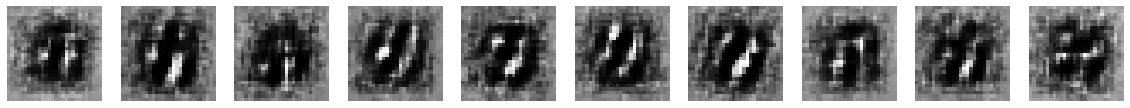

In [24]:
# 400 iteration (batch_size=32)
generated_img = model2_2.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]), cmap=cm.gray_r)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [25]:
model3_2 = DCGAN2()
model3_2.train(iterations=1000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 1024)              103424    
_________________________________________________________________
batch_normalization_25 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_42 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_26 (Batc (None, 6272)              25088     
_________________________________________________________________
activation_43 (Activation)   (None, 6272)              0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 7, 7, 128)         0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.705444, acc.: 33%] [G loss: 0.520769]
100 [ D loss: 0.014978, acc.: 100%] [G loss: 0.842866]
200 [ D loss: 0.014444, acc.: 100%] [G loss: 0.524388]
300 [ D loss: 0.463028, acc.: 84%] [G loss: 0.463942]
400 [ D loss: 0.006266, acc.: 100%] [G loss: 0.044432]
500 [ D loss: 0.009161, acc.: 100%] [G loss: 0.062752]
600 [ D loss: 0.009348, acc.: 100%] [G loss: 0.235408]
700 [ D loss: 0.007619, acc.: 100%] [G loss: 0.138612]
800 [ D loss: 0.108942, acc.: 95%] [G loss: 0.951818]
900 [ D loss: 0.058651, acc.: 98%] [G loss: 1.949367]


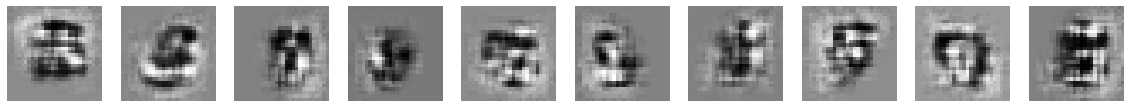

In [29]:
# 1000 iteration (batch_size=128)
generated_img = model3_2.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]), cmap=cm.gray_r)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [27]:
model4_2 = DCGAN2()
model4_2.train(iterations=1000, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 1024)              103424    
_________________________________________________________________
batch_normalization_28 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_47 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_29 (Batc (None, 6272)              25088     
_________________________________________________________________
activation_48 (Activation)   (None, 6272)              0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 7, 7, 128)         0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.694347, acc.: 34%] [G loss: 0.848285]
100 [ D loss: 0.012719, acc.: 100%] [G loss: 1.429449]
200 [ D loss: 0.002625, acc.: 100%] [G loss: 1.146775]
300 [ D loss: 0.104546, acc.: 94%] [G loss: 5.738060]
400 [ D loss: 0.015419, acc.: 100%] [G loss: 2.418095]
500 [ D loss: 0.024202, acc.: 100%] [G loss: 0.752009]
600 [ D loss: 0.015212, acc.: 100%] [G loss: 5.181028]
700 [ D loss: 0.039697, acc.: 100%] [G loss: 1.635782]
800 [ D loss: 0.059161, acc.: 97%] [G loss: 2.521410]
900 [ D loss: 0.018903, acc.: 100%] [G loss: 2.703151]


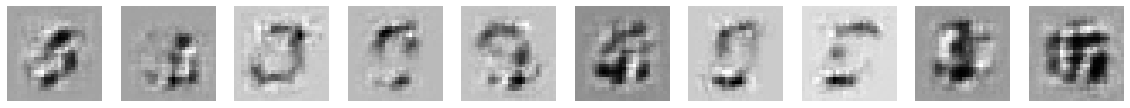

In [30]:
# 1000 iteration (batch_size=32)
generated_img = model4_2.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]), cmap=cm.gray_r)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [32]:
model5_2 = DCGAN2()
model5_2.train(iterations=2000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 1024)              103424    
_________________________________________________________________
batch_normalization_34 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_57 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_35 (Batc (None, 6272)              25088     
_________________________________________________________________
activation_58 (Activation)   (None, 6272)              0         
_________________________________________________________________
reshape_12 (Reshape)         (None, 7, 7, 128)         0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.683057, acc.: 70%] [G loss: 0.670999]
100 [ D loss: 0.009775, acc.: 100%] [G loss: 0.514033]
200 [ D loss: 0.013075, acc.: 100%] [G loss: 0.897197]
300 [ D loss: 0.035016, acc.: 100%] [G loss: 1.525598]
400 [ D loss: 0.006183, acc.: 100%] [G loss: 0.045923]
500 [ D loss: 0.015433, acc.: 100%] [G loss: 0.225139]
600 [ D loss: 0.045405, acc.: 98%] [G loss: 0.200682]
700 [ D loss: 0.067238, acc.: 98%] [G loss: 1.537958]
800 [ D loss: 0.022794, acc.: 99%] [G loss: 0.153569]
900 [ D loss: 0.039840, acc.: 100%] [G loss: 2.254817]
1000 [ D loss: 0.094075, acc.: 98%] [G loss: 1.315035]
1100 [ D loss: 0.029602, acc.: 100%] [G loss: 0.308385]
1200 [ D loss: 0.060065, acc.: 99%] [G loss: 0.410729]
1300 [ D loss: 0.113226, acc.: 98%] [G loss: 2.515110]
1400 [ D loss: 0.136131, acc.: 95%] [G loss: 1.945100]
1500 [ D loss: 0.045554, acc.: 99%] [G loss: 2.850927]
1600 [ D loss: 0.135747, acc.: 96%] [G loss: 2.203443]
1700 [ D loss: 0.087476, acc.: 99%] [G loss: 4.033012]
1800 [ D loss: 

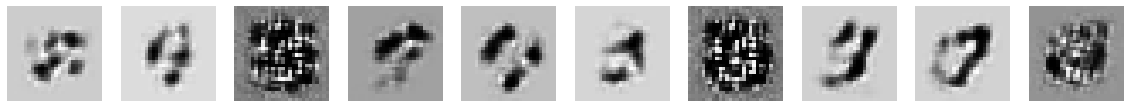

In [34]:
# 2000 iteration (batch_size=128)
generated_img = model5_2.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]), cmap=cm.gray_r)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [35]:
model6_2 = DCGAN2()
model6_2.train(iterations=10000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 1024)              103424    
_________________________________________________________________
batch_normalization_37 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_62 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_38 (Batc (None, 6272)              25088     
_________________________________________________________________
activation_63 (Activation)   (None, 6272)              0         
_________________________________________________________________
reshape_13 (Reshape)         (None, 7, 7, 128)         0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.659968, acc.: 90%] [G loss: 1.726593]
100 [ D loss: 0.074321, acc.: 100%] [G loss: 2.786515]
200 [ D loss: 0.007404, acc.: 100%] [G loss: 0.419996]
300 [ D loss: 0.006967, acc.: 100%] [G loss: 2.616106]
400 [ D loss: 0.034353, acc.: 99%] [G loss: 0.107471]
500 [ D loss: 0.023809, acc.: 100%] [G loss: 0.286120]
600 [ D loss: 0.022183, acc.: 100%] [G loss: 0.504923]
700 [ D loss: 0.022018, acc.: 100%] [G loss: 1.436505]
800 [ D loss: 0.048162, acc.: 99%] [G loss: 1.688469]
900 [ D loss: 0.016128, acc.: 100%] [G loss: 3.537760]
1000 [ D loss: 0.042955, acc.: 99%] [G loss: 2.656249]
1100 [ D loss: 0.025119, acc.: 100%] [G loss: 3.311472]
1200 [ D loss: 0.012953, acc.: 100%] [G loss: 1.122979]
1300 [ D loss: 0.032867, acc.: 99%] [G loss: 2.025028]
1400 [ D loss: 0.032269, acc.: 99%] [G loss: 2.241359]
1500 [ D loss: 0.013220, acc.: 100%] [G loss: 3.665437]
1600 [ D loss: 0.042444, acc.: 98%] [G loss: 3.915276]
1700 [ D loss: 0.009539, acc.: 100%] [G loss: 3.659229]
1800 [ D lo

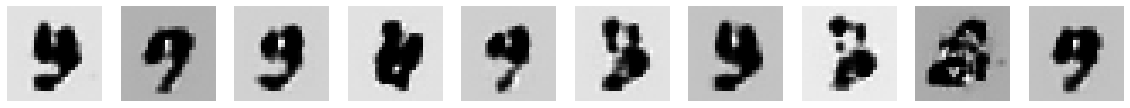

In [36]:
# 10000 iteration (batch_size=128)
generated_img = model6_2.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]), cmap=cm.gray_r)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [37]:
model7_2 = DCGAN2()
model7_2.train(iterations=4000, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 1024)              103424    
_________________________________________________________________
batch_normalization_40 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_67 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_56 (Dense)             (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_41 (Batc (None, 6272)              25088     
_________________________________________________________________
activation_68 (Activation)   (None, 6272)              0         
_________________________________________________________________
reshape_14 (Reshape)         (None, 7, 7, 128)         0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.693290, acc.: 38%] [G loss: 0.829523]
100 [ D loss: 0.003395, acc.: 100%] [G loss: 0.713489]
200 [ D loss: 0.006317, acc.: 100%] [G loss: 1.374647]
300 [ D loss: 0.002859, acc.: 100%] [G loss: 0.251785]
400 [ D loss: 0.008745, acc.: 100%] [G loss: 2.159301]
500 [ D loss: 0.024628, acc.: 100%] [G loss: 0.771334]
600 [ D loss: 0.103052, acc.: 97%] [G loss: 1.990556]
700 [ D loss: 0.012400, acc.: 100%] [G loss: 1.220768]
800 [ D loss: 0.029643, acc.: 100%] [G loss: 2.765437]
900 [ D loss: 0.136706, acc.: 97%] [G loss: 1.506177]
1000 [ D loss: 0.013496, acc.: 100%] [G loss: 2.213002]
1100 [ D loss: 0.013115, acc.: 100%] [G loss: 4.919113]
1200 [ D loss: 0.135456, acc.: 94%] [G loss: 2.454418]
1300 [ D loss: 0.018447, acc.: 100%] [G loss: 2.931148]
1400 [ D loss: 0.016981, acc.: 100%] [G loss: 3.726084]
1500 [ D loss: 0.077340, acc.: 97%] [G loss: 4.093264]
1600 [ D loss: 0.093050, acc.: 97%] [G loss: 2.657980]
1700 [ D loss: 0.038052, acc.: 100%] [G loss: 3.806727]
1800 [ D l

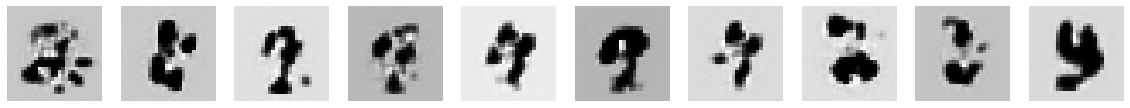

In [38]:
# 4000 iteration (batch_size=32)
generated_img = model6_2.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]), cmap=cm.gray_r)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [39]:
model8_2 = DCGAN2()
model8_2.train(iterations=15000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 1024)              103424    
_________________________________________________________________
batch_normalization_43 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_72 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_60 (Dense)             (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_44 (Batc (None, 6272)              25088     
_________________________________________________________________
activation_73 (Activation)   (None, 6272)              0         
_________________________________________________________________
reshape_15 (Reshape)         (None, 7, 7, 128)         0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [ D loss: 0.699236, acc.: 42%] [G loss: 0.792112]
100 [ D loss: 0.014304, acc.: 100%] [G loss: 0.802955]
200 [ D loss: 0.006323, acc.: 100%] [G loss: 0.663123]
300 [ D loss: 0.068270, acc.: 98%] [G loss: 0.985916]
400 [ D loss: 0.009089, acc.: 100%] [G loss: 0.076105]
500 [ D loss: 0.011239, acc.: 100%] [G loss: 0.110977]
600 [ D loss: 0.057758, acc.: 97%] [G loss: 0.260116]
700 [ D loss: 0.132058, acc.: 95%] [G loss: 0.842834]
800 [ D loss: 0.016478, acc.: 100%] [G loss: 0.133388]
900 [ D loss: 0.013366, acc.: 100%] [G loss: 0.012752]
1000 [ D loss: 0.069580, acc.: 98%] [G loss: 0.841686]
1100 [ D loss: 0.051184, acc.: 98%] [G loss: 0.191139]
1200 [ D loss: 0.113122, acc.: 95%] [G loss: 1.441456]
1300 [ D loss: 0.144494, acc.: 95%] [G loss: 3.491096]
1400 [ D loss: 0.047916, acc.: 99%] [G loss: 0.978774]
1500 [ D loss: 0.184300, acc.: 95%] [G loss: 1.348680]
1600 [ D loss: 0.063346, acc.: 98%] [G loss: 3.704402]
1700 [ D loss: 0.100761, acc.: 97%] [G loss: 3.248835]
1800 [ D loss: 0

KeyboardInterrupt: ignored

In [0]:
# 15000 iteration (batch_size=128)
generated_img = model6_2.generator.predict(np.random.normal(0, 1, (10, 100)))


import matplotlib.pyplot as plt

plt.figure(figsize=(20, 2))
n =10
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(np.squeeze(generated_img[i]), cmap=cm.gray_r)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)